❌ Failed to fetch live data: 500 Server Error: INTERNAL SERVER ERROR for url: http://127.0.0.1:5000/fetch_data?lat=20.859764&lon=77.736801


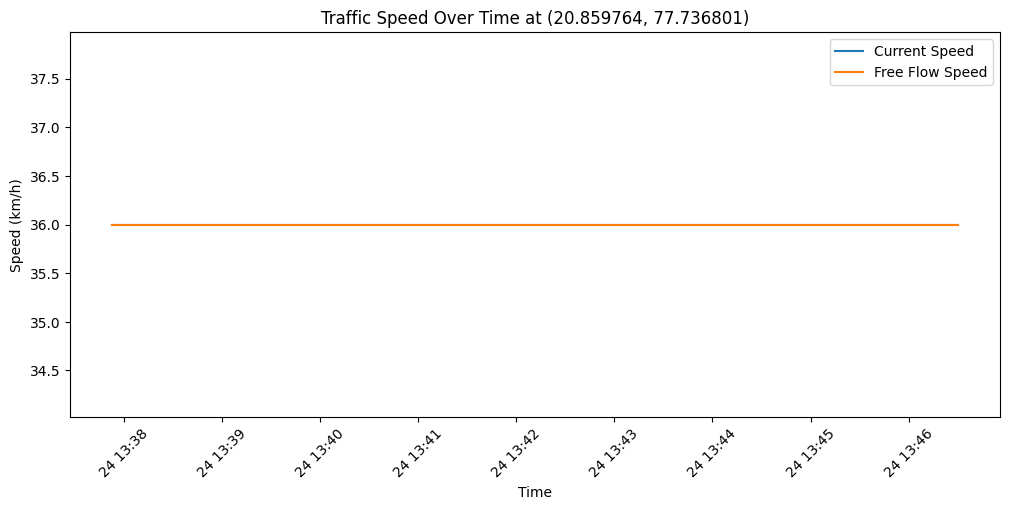

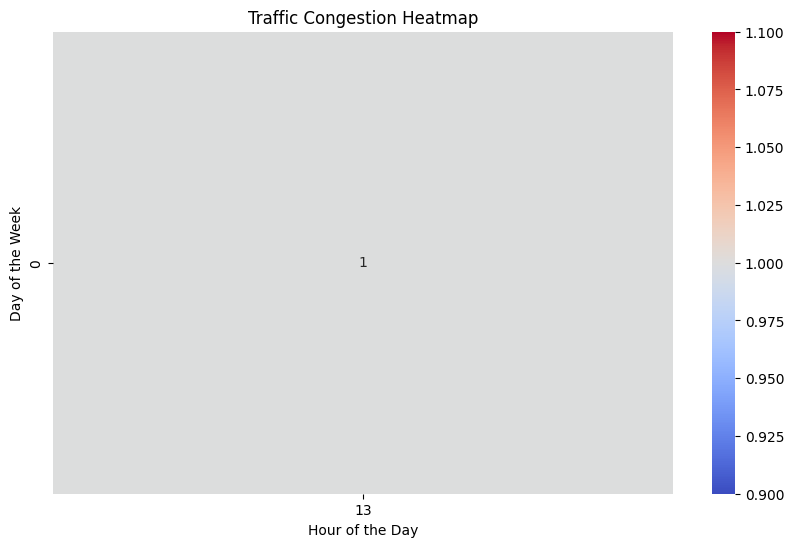

Model Performance: MAE=0.00, MSE=0.00
✅ Data Ready for Power BI / Google Data Studio Analysis!


In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import requests
import os

# Load Data from SQLite Database
def load_data(latitude, longitude):
    conn = sqlite3.connect("../backend/database.db")
    query = """
        SELECT * FROM traffic_data
        WHERE latitude = ? AND longitude = ?
    """
    df = pd.read_sql_query(query, conn, params=(latitude, longitude))
    conn.close()
    return df

# Fetch Real-Time Data from Backend API
def fetch_live_data(latitude, longitude):
    try:
        response = requests.get(
            "http://127.0.0.1:5000/fetch_data",
            params={"lat": latitude, "lon": longitude},
            timeout=5
        )
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"❌ Failed to fetch live data: {e}")
        return None

# User Input
latitude, longitude = 20.859764, 77.736801
fetch_live_data(latitude, longitude)
df = load_data(latitude, longitude)

if df.empty:
    print("❌ No data found for this location!")
    exit()

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['traffic_index'] = df['current_speed'] / df['free_flow_speed']  # Traffic Congestion Metric

# Data Visualization
plt.figure(figsize=(12, 5))
sns.lineplot(x=df['timestamp'], y=df['current_speed'], label='Current Speed')
sns.lineplot(x=df['timestamp'], y=df['free_flow_speed'], label='Free Flow Speed')
plt.title(f"Traffic Speed Over Time at ({latitude}, {longitude})")
plt.xlabel("Time")
plt.ylabel("Speed (km/h)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Heatmap for Traffic Congestion
plt.figure(figsize=(10, 6))
sns.heatmap(df.pivot_table(index='day_of_week', columns='hour', values='traffic_index', aggfunc='mean'), cmap='coolwarm', annot=True)
plt.title("Traffic Congestion Heatmap")
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week")
plt.show()

# Prepare Data for ML Model
features = df[['hour', 'day_of_week']]
target = df['current_speed']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train Model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Model Performance: MAE={mae:.2f}, MSE={mse:.2f}")

# Save Predictions for Power BI
output_dir = "../analytics"
os.makedirs(output_dir, exist_ok=True)
df_predictions = pd.DataFrame({
    "timestamp": df['timestamp'][X_test.index],
    "latitude": latitude,
    "longitude": longitude,
    "predicted_speed": y_pred,
    "current_speed": df['current_speed'][X_test.index],
    "free_flow_speed": df['free_flow_speed'][X_test.index],
    "traffic_index": df['traffic_index'][X_test.index]
})
df_predictions.to_csv(os.path.join(output_dir, "predicted_traffic.csv"), index=False)

print("✅ Data Ready for Power BI / Google Data Studio Analysis!")
